In [2]:
#this cell contains all the imports needed by the pipeline
#to run it on the browser: jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10
import os
import json
import time

import matplotlib.pyplot as plt
import numpy as np
import statistics
from scipy.optimize import minimize

from qiskit_optimization import QuadraticProgram
from qiskit.primitives import BackendSampler
from qiskit_algorithms.utils import algorithm_globals
from qiskit_ibm_runtime.fake_provider import FakeVigoV2
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.circuit.library import QAOAAnsatz

from mitiq import zne
from mitiq.zne.inference import RichardsonFactory
from mitiq.zne.scaling import fold_global

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster
from collections import defaultdict

In [3]:
#this cell contains all variable definitions that will be useful throughout the entire project
sir_programs = ["flex","grep","gzip","sed"]
sir_programs_tests_number = {"flex":567,"grep":806,"gzip":214,"sed":360}
sir_programs_end_lines = {"flex":14192,"grep":13281,"gzip":6701,"sed":7118}
sir_programs_rep_values = {"flex":1,"grep":16,"gzip":1,"sed":1}
alpha = 0.5
experiments = 10

In [4]:
def json_keys_to_int(d):
    """This method correctly converts the data"""
    if isinstance(d, dict):
        return {int(k) if k.isdigit() else k: json_keys_to_int(v) for k, v in d.items()}
    elif isinstance(d, list):
        return [json_keys_to_int(i) for i in d]
    else:
        return d


with open("datasets/sir_programs/executed_lines_test_by_test.json", "r") as file:
    #dictionary that, for each sir program, associates at each LINE of that program the LIST of TESTS COVERING it
    executed_lines_test_by_test = json_keys_to_int(json.load(file)) #{program1:{line:[tci,tcj,...,tck],line2:...}
with open("datasets/sir_programs/faults_dictionary.json", "r") as file:
    #dictionary that associates at each SIR PROGRAM the LIST of PAST FAULT COVERAGE VALUES ORDERED BY TEST 
    faults_dictionary = json.load(file) #{program1:[fault_cov_tc1,fault_cov_tc2,...,fault_cov_tcn],program2:...}
with open("datasets/sir_programs/test_coverage_line_by_line.json", "r") as file:
    #dictionary that, for each sir program, associates at each TEST of that program the LIST of LINES COVERED by it
    test_coverage_line_by_line = json_keys_to_int(json.load(file)) #{program1:{tc1:[linei,linej,...,linek],tc2:...}
with open("datasets/sir_programs/test_cases_costs.json", "r") as file:
    #dictionary that, for each sir program, associates at each TEST its EXECUTION COST
    test_cases_costs = json_keys_to_int(json.load(file)) #{program1:{tc1:ex_cost1,tc2:ex_cost2,...,tcn:ex_costn},program2:...}
with open("datasets/sir_programs/total_program_lines.json", "r") as file:
    #dictionary which associates at each SIR PROGRAM its size in terms of the NUMBER OF ITS LINES
    total_program_lines = json.load(file) #{program1:tot_lines_program1,program2:tot_lines_program2,program3:...}

SelectQAOA Decomposition Time(ms): 3.3600330352783203
Cluster 12 metrics:
Test Cases: [15, 17, 411, 416, 436]
 - Num. Test Cases: 5.00
 - Execution Cost: 779748.00
 - Past Fault Coverage (%): 0.008818342151675485
 - Statement Coverage (%): 0.34

Cluster 2 metrics:
Test Cases: [16, 532]
 - Num. Test Cases: 2.00
 - Execution Cost: 399087.00
 - Past Fault Coverage (%): 0.0
 - Statement Coverage (%): 0.43

Cluster 7 metrics:
Test Cases: [22, 23, 24, 526]
 - Num. Test Cases: 4.00
 - Execution Cost: 237376.00
 - Past Fault Coverage (%): 0.0
 - Statement Coverage (%): 0.25

Cluster 40 metrics:
Test Cases: [54, 64, 179, 189, 194]
 - Num. Test Cases: 5.00
 - Execution Cost: 2888516.00
 - Past Fault Coverage (%): 0.008818342151675485
 - Statement Coverage (%): 0.40

Cluster 10 metrics:
Test Cases: [318]
 - Num. Test Cases: 1.00
 - Execution Cost: 24461.00
 - Past Fault Coverage (%): 0.0
 - Statement Coverage (%): 0.17

Cluster 33 metrics:
Test Cases: [319, 359, 449, 489, 564]
 - Num. Test Cases:

/var/folders/kn/kd67nwcs41113fgwjn39d7fm0000gn/T/ipykernel_3210/681956930.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_clusters)  # A colormap with as many colors as clusters


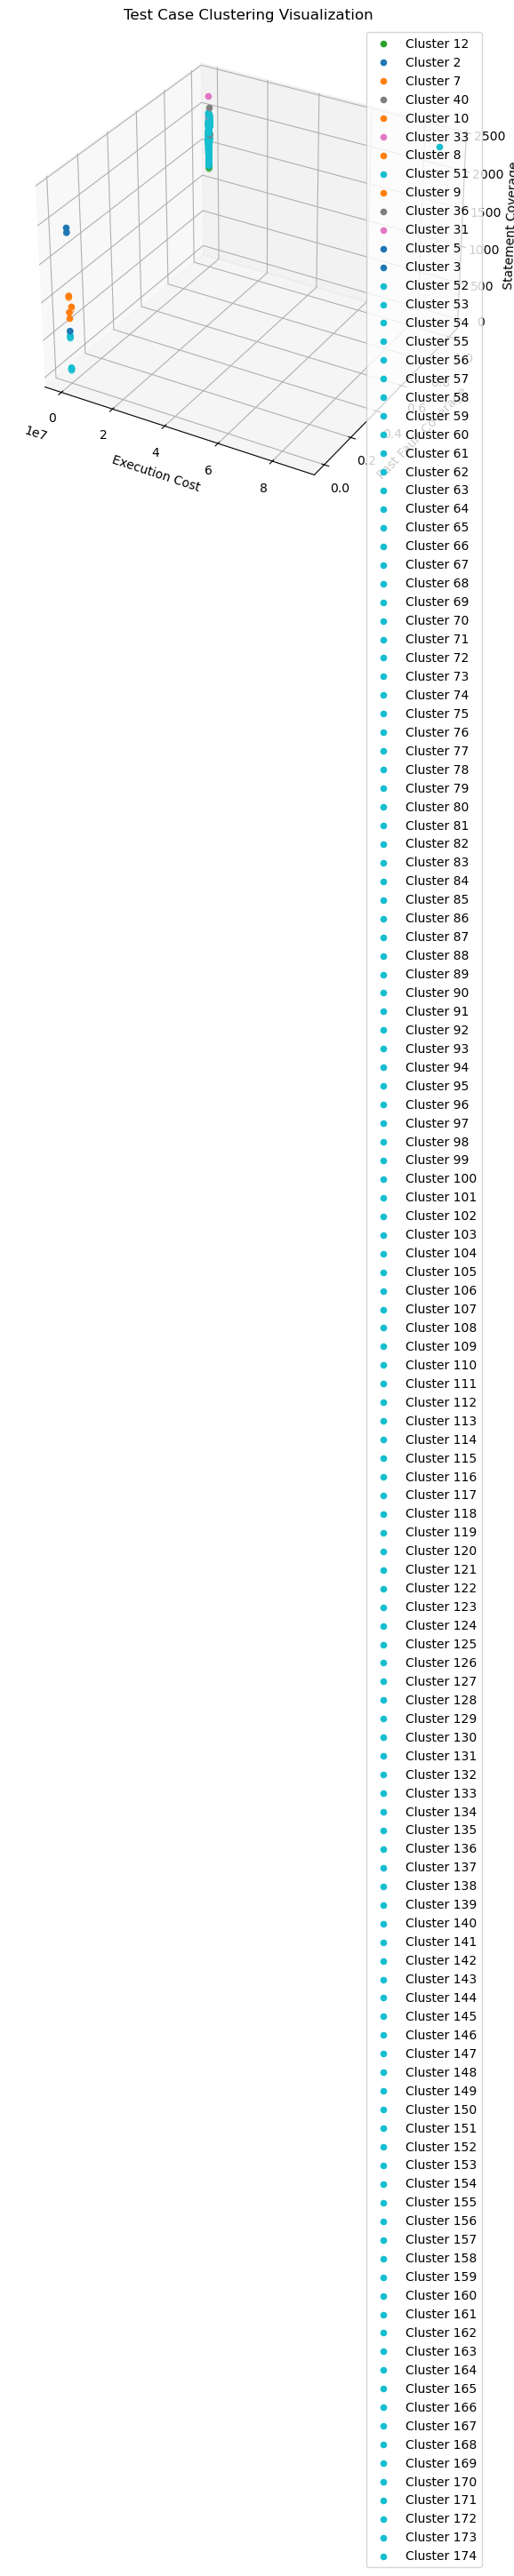

SelectQAOA Decomposition Time(ms): 5.482912063598633
Cluster 15 metrics:
Test Cases: [19, 31, 35, 266]
 - Num. Test Cases: 4.00
 - Execution Cost: 3714584.00
 - Past Fault Coverage (%): 0.004962779156327543
 - Statement Coverage (%): 0.33

Cluster 39 metrics:
Test Cases: [27, 724, 725, 801]
 - Num. Test Cases: 4.00
 - Execution Cost: 2310482.00
 - Past Fault Coverage (%): 0.0
 - Statement Coverage (%): 0.28

Cluster 48 metrics:
Test Cases: [32, 267, 504, 793]
 - Num. Test Cases: 4.00
 - Execution Cost: 3600625.00
 - Past Fault Coverage (%): 0.0
 - Statement Coverage (%): 0.28

Cluster 2 metrics:
Test Cases: [133, 360]
 - Num. Test Cases: 2.00
 - Execution Cost: 684648.00
 - Past Fault Coverage (%): 0.0024813895781637717
 - Statement Coverage (%): 0.27

Cluster 13 metrics:
Test Cases: [134, 323, 361]
 - Num. Test Cases: 3.00
 - Execution Cost: 2389947.00
 - Past Fault Coverage (%): 0.0037220843672456576
 - Statement Coverage (%): 0.31

Cluster 23 metrics:
Test Cases: [482, 620, 622, 691

/var/folders/kn/kd67nwcs41113fgwjn39d7fm0000gn/T/ipykernel_3210/681956930.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_clusters)  # A colormap with as many colors as clusters


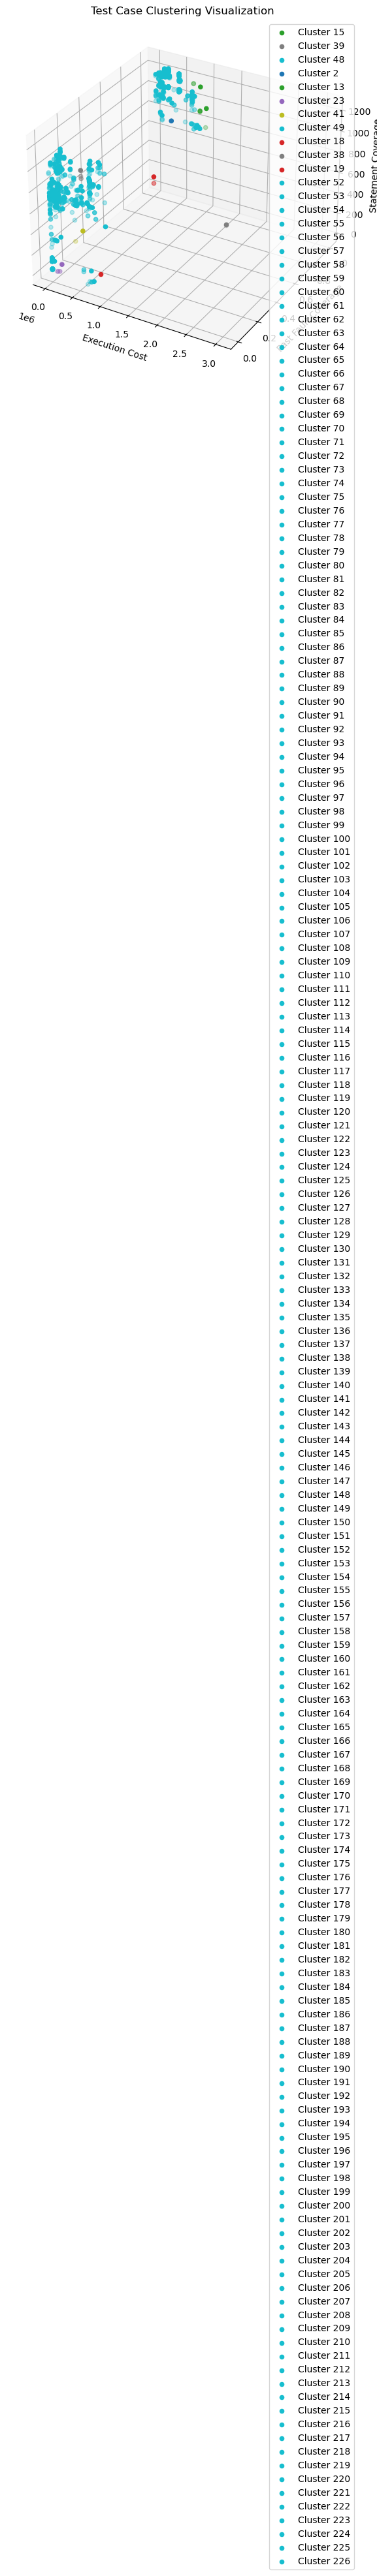

SelectQAOA Decomposition Time(ms): 0.80108642578125
Cluster 15 metrics:
Test Cases: [0, 1, 2, 3]
 - Num. Test Cases: 4.00
 - Execution Cost: 216.00
 - Past Fault Coverage (%): 0.0
 - Statement Coverage (%): 0.03

Cluster 14 metrics:
Test Cases: [4, 5]
 - Num. Test Cases: 2.00
 - Execution Cost: 112.00
 - Past Fault Coverage (%): 0.0
 - Statement Coverage (%): 0.02

Cluster 11 metrics:
Test Cases: [8, 10, 11, 19, 21]
 - Num. Test Cases: 5.00
 - Execution Cost: 823864.00
 - Past Fault Coverage (%): 0.0
 - Statement Coverage (%): 0.17

Cluster 17 metrics:
Test Cases: [9]
 - Num. Test Cases: 1.00
 - Execution Cost: 115.00
 - Past Fault Coverage (%): 0.0
 - Statement Coverage (%): 0.04

Cluster 45 metrics:
Test Cases: [15, 64, 84, 144, 210]
 - Num. Test Cases: 5.00
 - Execution Cost: 9360864.00
 - Past Fault Coverage (%): 0.02336448598130841
 - Statement Coverage (%): 0.25

Cluster 19 metrics:
Test Cases: [16, 17, 18]
 - Num. Test Cases: 3.00
 - Execution Cost: 480.00
 - Past Fault Coverage

/var/folders/kn/kd67nwcs41113fgwjn39d7fm0000gn/T/ipykernel_3210/681956930.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_clusters)  # A colormap with as many colors as clusters


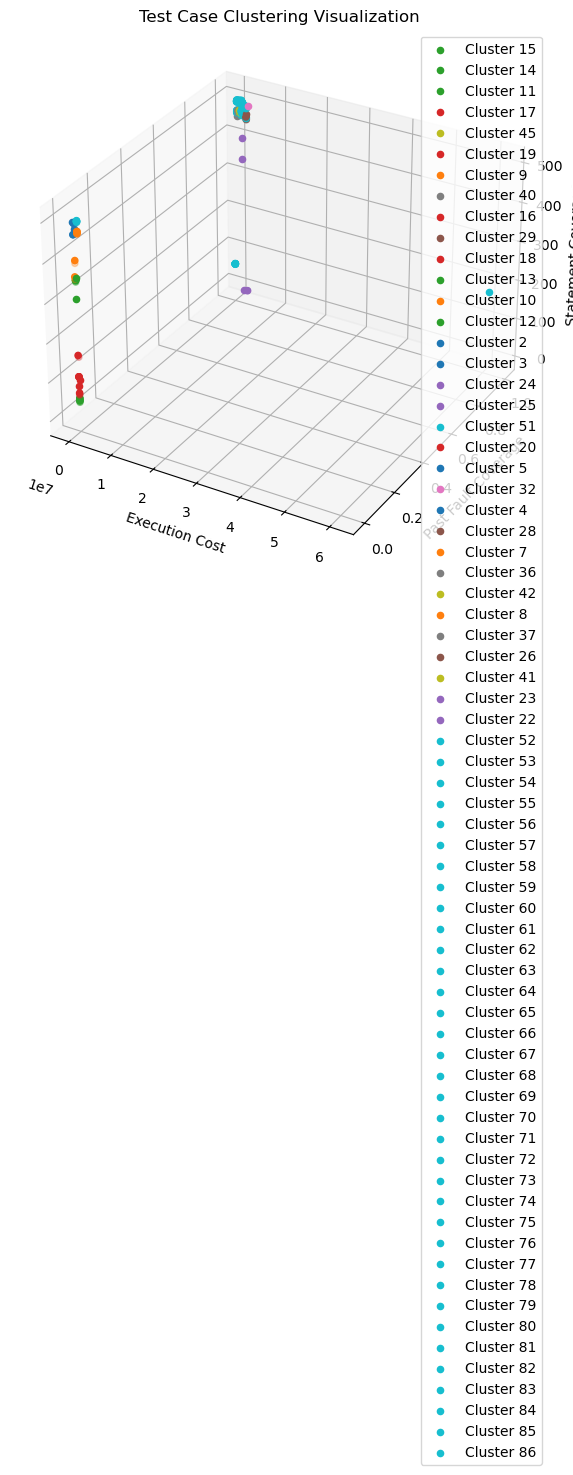

SelectQAOA Decomposition Time(ms): 1.9922256469726562
Cluster 11 metrics:
Test Cases: [0, 1, 4, 10, 11]
 - Num. Test Cases: 5.00
 - Execution Cost: 505.00
 - Past Fault Coverage (%): 0.013888888888888888
 - Statement Coverage (%): 0.02

Cluster 13 metrics:
Test Cases: [2, 3, 13, 14]
 - Num. Test Cases: 4.00
 - Execution Cost: 176.00
 - Past Fault Coverage (%): 0.0
 - Statement Coverage (%): 0.01

Cluster 14 metrics:
Test Cases: [17, 31]
 - Num. Test Cases: 2.00
 - Execution Cost: 4560.00
 - Past Fault Coverage (%): 0.0
 - Statement Coverage (%): 0.17

Cluster 15 metrics:
Test Cases: [18, 277]
 - Num. Test Cases: 2.00
 - Execution Cost: 102154.00
 - Past Fault Coverage (%): 0.0
 - Statement Coverage (%): 0.10

Cluster 42 metrics:
Test Cases: [26, 49, 51]
 - Num. Test Cases: 3.00
 - Execution Cost: 322243.00
 - Past Fault Coverage (%): 0.008333333333333333
 - Statement Coverage (%): 0.31

Cluster 21 metrics:
Test Cases: [27]
 - Num. Test Cases: 1.00
 - Execution Cost: 262595.00
 - Past F

/var/folders/kn/kd67nwcs41113fgwjn39d7fm0000gn/T/ipykernel_3210/681956930.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_clusters)  # A colormap with as many colors as clusters


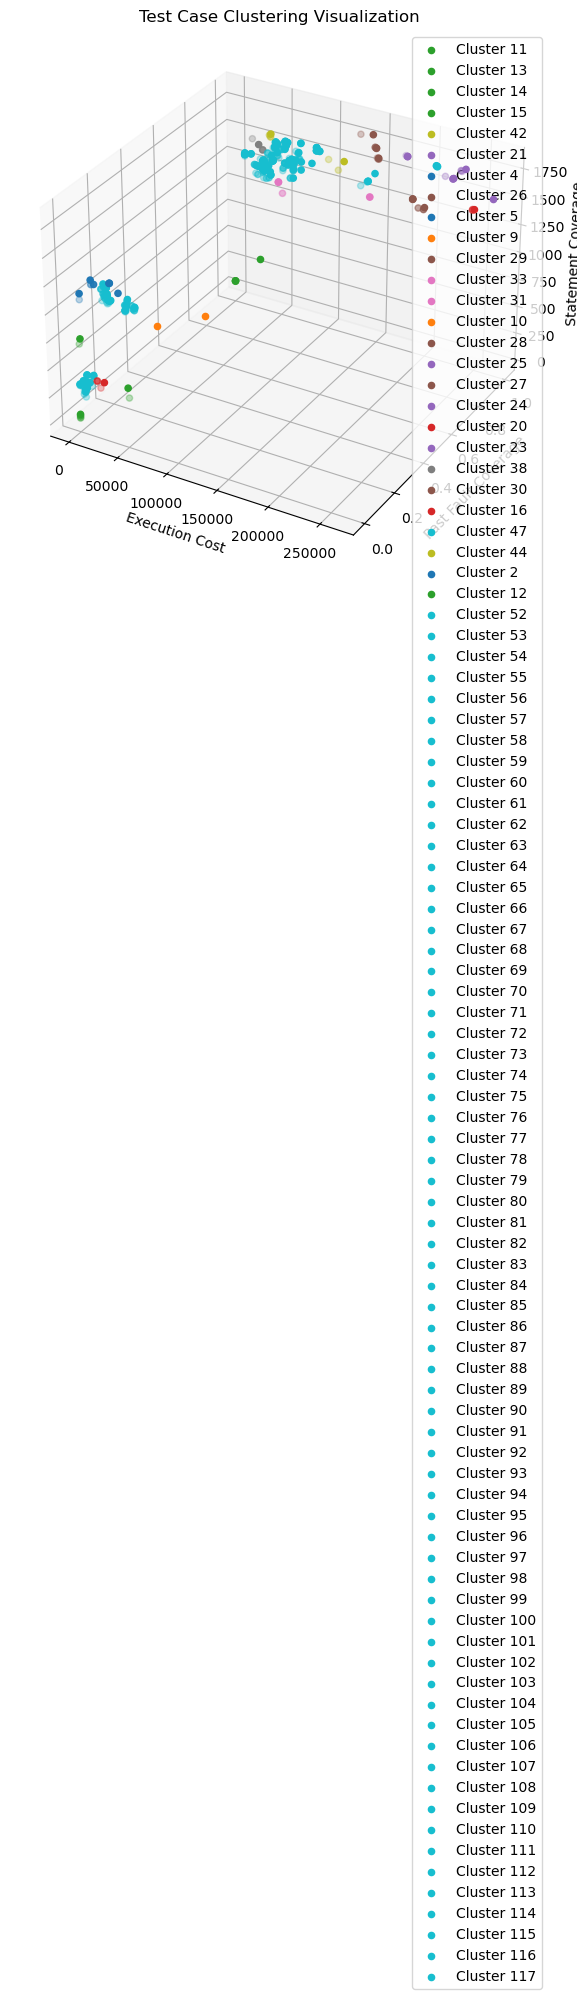

{'flex': defaultdict(<class 'list'>, {11: [15, 17, 411, 416, 436], 1: [16, 532], 6: [22, 23, 24, 526], 39: [54, 64, 179, 189, 194], 9: [318], 32: [319, 359, 449, 489, 564], 7: [528, 547], 50: [533], 8: [549, 550], 35: [554], 30: [555, 556], 4: [557, 558], 2: [560], 51: [0, 2, 11, 542], 52: [551, 552, 553], 53: [1, 204, 244, 329], 54: [369, 459, 499, 519], 55: [3, 10, 43, 66, 70], 56: [82, 106, 122, 147, 157], 57: [196, 200, 230, 236, 240], 58: [278, 288, 333, 343, 373], 59: [383, 398, 408, 482, 503], 60: [513, 523, 525, 530], 61: [4, 40, 45, 52, 55], 62: [62, 91, 131, 170, 177], 63: [180, 192, 221, 261, 271], 64: [346, 386, 476, 540, 541], 65: [5, 25, 34, 80, 86], 66: [120, 126, 145, 155, 216], 67: [250, 256, 266, 277, 283], 68: [287, 293, 316, 322, 340], 69: [353, 362, 380, 393, 397], 70: [403, 462, 502, 510, 522], 71: [539], 72: [6, 32, 50, 60, 81], 73: [121, 146, 156, 175, 188], 74: [190, 231, 295, 305, 321], 75: [361, 420, 430, 471, 511], 76: [521, 527, 543], 77: [7, 37, 96, 136, 2

In [5]:
def num_of_covered_lines(sir_program,test_cases):
    """This method returns the number of covered lines (no redundancy)"""
    covered_lines = set()
    
    for test_case in test_cases:
        try:
            for covered_line in test_coverage_line_by_line[sir_program][test_case]:
                covered_lines.add(covered_line)
        except:
            continue
    
    return len(covered_lines)

clusters_dictionary = dict()

for sir_program in sir_programs:
    tot_test_cases = sir_programs_tests_number[sir_program]
    
    # from {..., test_case_i : [cov_stmts], ...} to [..., #_stmt_cov_i, ...]
    test_cases_stmt_cov = []
    for test_case in test_coverage_line_by_line[sir_program].keys():
        test_cases_stmt_cov.append(len(test_coverage_line_by_line[sir_program][test_case]))
    suite_stmt_cov = sum(test_cases_stmt_cov)
    
    # Normalize data
    data = np.column_stack((list(test_cases_costs[sir_program].values()),faults_dictionary[sir_program],test_cases_stmt_cov))
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data)

    num_clusters = 50
        
    max_cluster_dim = 5
    
    # Step 2: Perform K-Means Clustering
    start = time.time()
    linkage_matrix = linkage(normalized_data, method='ward')
    clusters = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')
    
    # Organize test cases by cluster
    clustered_data = defaultdict(list)
    for idx, cluster_id in enumerate(clusters):
        clustered_data[cluster_id].append(idx)
    
    # Process clusters to ensure none exceed max_cluster_dim
    new_cluster_id = max(clustered_data.keys()) + 1  # Start new IDs after existing ones
    to_add = []  # Collect new smaller clusters
    
    for cluster_id, elements in list(clustered_data.items()):  # Avoid modifying dict during iteration
        if len(elements) > max_cluster_dim:
            num_splits = -(-len(elements) // max_cluster_dim)  # Ceiling division to get the required number of splits
            split_size = -(-len(elements) // num_splits)  # Recalculate to distribute elements evenly
            
            # Split while keeping sizes balanced
            parts = [elements[i:i + split_size] for i in range(0, len(elements), split_size)]
    
            # Ensure all new clusters are within max_cluster_dim
            for part in parts:
                if len(part) > max_cluster_dim:
                    raise ValueError(f"A split cluster still exceeds max_cluster_dim ({len(part)} > {max_cluster_dim})!")
    
            # Add new parts to the new clusters
            to_add.extend(parts)
    
            # Remove original large cluster
            del clustered_data[cluster_id]
    
    # Assign new IDs to split parts
    for part in to_add:
        if part:  # Only add if the part is non-empty
            clustered_data[new_cluster_id] = part
            new_cluster_id += 1
    end = time.time()
    print("SelectQAOA Decomposition Time(ms): " + str((end-start)*1000))
    
    clusters_dictionary[sir_program] = clustered_data
        
    # Step 3: Calculate the metrics for each cluster and validate
    cluster_metrics = {}
    for cluster_id in clustered_data.keys():
        tot_cluster_exec_cost = 0
        tot_cluster_past_fault_cov = 0
        tot_cluster_stmt_cov = 0
        for test_case in clustered_data[cluster_id]:
            tot_cluster_exec_cost += test_cases_costs[sir_program][test_case]
            tot_cluster_past_fault_cov += faults_dictionary[sir_program][test_case]
        tot_cluster_past_fault_cov = tot_cluster_past_fault_cov/tot_test_cases
        tot_cluster_stmt_cov = num_of_covered_lines(sir_program,clustered_data[cluster_id])/total_program_lines[sir_program]
        cluster_metrics[cluster_id] = {
            "tot_exec_cost": tot_cluster_exec_cost,
            "tot_past_fault_cov": tot_cluster_past_fault_cov,
            "tot_stmt_cov": tot_cluster_stmt_cov  # Avg stmt coverage per test case in cluster
        }
        print(f"Cluster {cluster_id + 1} metrics:")
        print(f"Test Cases: {clustered_data[cluster_id]}")
        print(f" - Num. Test Cases: {len(clustered_data[cluster_id]):.2f}")
        print(f" - Execution Cost: {tot_cluster_exec_cost:.2f}")
        print(f" - Past Fault Coverage (%): {tot_cluster_past_fault_cov}")
        print(f" - Statement Coverage (%): {tot_cluster_stmt_cov:.2f}\n")
    
    for cluster_id in clustered_data.keys():
        print("Test cases of cluster " + str(cluster_id) + ": " + str(len(clustered_data[cluster_id])))
    
    print("======================================================================================")
    
    print("Program Name: " + sir_program)
    
    for cluster_id in clustered_data.keys():
        if len(clustered_data[cluster_id]) > max_cluster_dim:
            print("Test cases of cluster " + str(cluster_id) + ": " + str(len(clustered_data[cluster_id])))
    
    # Plotting the clusters in 3D space
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Extracting data for plotting
    exec_costs = np.array(list(test_cases_costs[sir_program].values()))
    fault_covs = np.array(faults_dictionary[sir_program])
    stmt_covs = np.array(test_cases_stmt_cov)
    
    # Plot each cluster with a different color
    colors = plt.cm.get_cmap("tab10", num_clusters)  # A colormap with as many colors as clusters
    for cluster_id in clustered_data.keys():
        cluster_indices = clustered_data[cluster_id]
        
        # Plot each cluster's points
        ax.scatter(
            exec_costs[cluster_indices], 
            fault_covs[cluster_indices], 
            stmt_covs[cluster_indices], 
            color=colors(cluster_id), 
            label=f"Cluster {cluster_id + 1}"
        )
    
    # Label the axes
    ax.set_xlabel("Execution Cost")
    ax.set_ylabel("Past Fault Coverage")
    ax.set_zlabel("Statement Coverage")
    ax.legend()
    ax.set_title("Test Case Clustering Visualization")
    
    # Display the plot
    plt.show()
    
print(clusters_dictionary)

In [6]:
def make_linear_terms(sir_program, cluster_test_cases, alpha):
    """Making the linear terms of QUBO"""
    max_cost = max(test_cases_costs[sir_program].values())
    
    estimated_costs = []

    #linear coefficients, that are the diagonal of the matrix encoding the QUBO
    for test_case in cluster_test_cases:
        estimated_costs.append((alpha * (test_cases_costs[sir_program][test_case]/max_cost)) - (1 - alpha) * faults_dictionary[sir_program][test_case])
    
    return np.array(estimated_costs)

def make_quadratic_terms(sir_program, variables, cluster_test_cases, linear_terms, penalty):
    """Making the quadratic terms of QUBO"""
    quadratic_terms = {}
    
    #k is a stmt
    for k in executed_lines_test_by_test[sir_program].keys():
        #k_test_cases is the list of test cases covering k
        k_test_cases = executed_lines_test_by_test[sir_program][k]
        for i in k_test_cases:
            if i not in cluster_test_cases or i not in variables:
                continue
            for j in k_test_cases:
                if j not in cluster_test_cases or j not in variables:
                    continue
                if i < j:
                    linear_terms[variables.index(i)] -= penalty
                    try:
                        quadratic_terms[variables.index(i),variables.index(j)] += 2 * penalty
                    except:
                        quadratic_terms[variables.index(i),variables.index(j)] = 2 * penalty
    
    return quadratic_terms

In [7]:
def create_QUBO_problem(linear_terms, quadratic_terms):
    """This function is the one that has to encode the QUBO problem that QAOA will have to solve. The QUBO problem specifies the optimization to solve and a quadratic binary unconstrained problem"""
    qubo = QuadraticProgram()
    
    for i in range(0,len(linear_terms)):
        qubo.binary_var('x%s' % (i))

    qubo.minimize(linear=linear_terms,quadratic=quadratic_terms)

    return qubo


In [8]:
penalties_dictionary = {"flex":None,"grep":None,"gzip":None,"sed":None}

#to get a QUBO problem from a quadratic problem with constraints, we have to insert those constraints into the Hamiltonian to solve (which is the one encoded by the QUBO problem). When we insert constraint into the Hamiltonian, we have to specify also penalties
for sir_program in sir_programs:
    max_penalty = 0
    max_cost = max(test_cases_costs[sir_program].values())
    for i in range(sir_programs_tests_number[sir_program]):
        cost = (alpha * (test_cases_costs[sir_program][i]/max_cost)) - ((1 - alpha) * faults_dictionary[sir_program][i])
        if cost > max_penalty:
            max_penalty = cost
    penalties_dictionary[sir_program] = max_penalty + 1

In [9]:
qubos_dictionary = {"flex":[],"grep":[],"gzip":[],"sed":[]}
#make a dictionary that saves, for each program, the correspondent QUBO
for sir_program in sir_programs:
    print("SIR Program:\n")
    for cluster_id in clusters_dictionary[sir_program]:
        print("Cluster ID: " + str(cluster_id))
        variables = []
        for idx in range(0, len(clusters_dictionary[sir_program][cluster_id])):
            variables.append(idx)
        linear_terms = make_linear_terms(sir_program, clusters_dictionary[sir_program][cluster_id], alpha)
        quadratic_terms = make_quadratic_terms(sir_program, variables, clusters_dictionary[sir_program][cluster_id], linear_terms, penalties_dictionary[sir_program])
        qubo = create_QUBO_problem(linear_terms, quadratic_terms)
        qubos_dictionary[sir_program].append(qubo)
        print(qubo)
        print("/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/")
    print("======================================================================================")

SIR Program:

Cluster ID: 11
minimize -0.499131013001656*x0 - 0.4990897572319509*x1 - 0.4990981854057292*x2 - 0.49909349494380045*x3 - 0.4991916620274127*x4 (5 variables, 0 constraints, '')
/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/
Cluster ID: 1
minimize 0.0013371762799055705*x0 + 0.0009127063880765301*x1 (2 variables, 0 constraints, '')
/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/
Cluster ID: 6
minimize 0.00031149853775413127*x0 + 0.00036618864733448434*x1 + 0.00032578415136887357*x2 + 0.0003347535322927311*x3 (4 variables, 0 constraints, '')
/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/
Cluster ID: 39
minimize -0.49674405271132094*x0 - 0.49674404707374653*x1 - 0.49674408089919314*x2 - 0.49674416546280964*x3 - 0.4967394299002854*x4 (5 variables, 0 constraints, '')
/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/--/
Cluster ID: 9

In [10]:
def covered_lines(sir_program,test_cases_list):
    """Number of covered lines (no redundancy)"""
    covered_lines = set()
    
    for test_case in test_cases_list:
        try:
            for covered_line in test_coverage_line_by_line[sir_program][test_case]:
                covered_lines.add(covered_line)
        except:
            continue
    
    return len(covered_lines)

def build_pareto_front(sir_program,selected_tests):
    """This method builds the pareto front additionally from a sub test suite solution"""
    pareto_front = []
    max_fault_coverage = 0
    max_stmt_coverage = 0
    
    for index in range(1,len(selected_tests)+1):
        #exract the first index selected tests
        candidate_solution = selected_tests[:index]
        candidate_solution_fault_coverage = 0
        candidate_solution_stmt_coverage = 0
        for selected_test in candidate_solution:
            candidate_solution_fault_coverage += faults_dictionary[sir_program][selected_test]
            candidate_solution_stmt_coverage += covered_lines(sir_program,candidate_solution)
        #if the actual pareto front dominates the candidate solution, get to the next candidate
        if max_fault_coverage >= candidate_solution_fault_coverage and max_stmt_coverage >= candidate_solution_stmt_coverage:
            continue
        #eventually update the pareto front information
        if candidate_solution_stmt_coverage > max_stmt_coverage:
            max_stmt_coverage = candidate_solution_stmt_coverage
        if candidate_solution_fault_coverage > max_fault_coverage:
            max_fault_coverage = candidate_solution_fault_coverage
        #add the candidate solution to the pareto front
        pareto_front.append(candidate_solution)
    
    return pareto_front

In [ ]:
def expectation_from_distribution(distribution, operator):
    expectation = 0.0
    for pauli, coeff in zip(operator.paulis, operator.coeffs):
        pauli_str = pauli.to_label()
        if any(p in pauli_str for p in "XY"):
            continue
        for bitstring, prob in distribution.items():
            if len(pauli_str) < len(bitstring):
                pauli_str = pauli_str.rjust(len(bitstring), "I")
            parity = 1
            for i in range(len(bitstring)):
                p = pauli_str[-(i + 1)]
                if p == 'Z':
                    parity *= 1 if bitstring[-(i + 1)] == '0' else -1
            expectation += coeff.real * prob * parity
    return expectation.real

# Setup backend and seed
device_backend = FakeVigoV2()
algorithm_globals.random_seed = 10598

# Setup ZNE
scale_factors = [1.0, 3.0, 5.0]
factory = RichardsonFactory(scale_factors=scale_factors)
scale_noise = fold_global

# Main loop
for sir_program in sir_programs:
    print(f"Running program: {sir_program}")
    file_path = f"results/selectqaoa/fake_vigo_zne/{sir_program}-data.json"
    json_data = {}
    qpu_run_times = []
    pareto_fronts_building_times = []

    for i in range(experiments):
        final_selected_tests = []
        cluster_dict_index = 0

        for qubo in qubos_dictionary[sir_program]:
            print(f"Experiment {i}, QUBO {cluster_dict_index}")
            cluster_tests = list(clusters_dictionary[sir_program].values())[cluster_dict_index]
            print("Cluster's Test Cases:", cluster_tests)

            # Convert QUBO to Ising
            qp2qubo = QuadraticProgramToQubo()
            qubo_problem = qp2qubo.convert(qubo)
            hamiltonian, _ = qubo_problem.to_ising()
            reps = sir_programs_rep_values[sir_program]
            ansatz = QAOAAnsatz(hamiltonian, reps=reps)

            def zne_expectation(params):
                circuit = ansatz.assign_parameters(params)
                circuit.measure_all()
                def run_expectation(circ):
                    sampler = BackendSampler(backend=device_backend)
                    result = sampler.run(circ).result()
                    dist = result.quasi_dists[0].binary_probabilities()
                    return expectation_from_distribution(dist, hamiltonian)
                return zne.execute_with_zne(circuit, run_expectation, scale_noise=scale_noise, factory=factory)

            initial_params = np.array([0.5] * ansatz.num_parameters)
            result = minimize(zne_expectation, initial_params, method="COBYLA")
            optimal_params = result.x

            final_circuit = ansatz.assign_parameters(optimal_params)
            final_circuit.measure_all()
            sampler = BackendSampler(backend=device_backend)

            s = time.time()
            final_result = sampler.run(final_circuit).result()
            e = time.time()
            dist = final_result.quasi_dists[0].binary_probabilities()
            best_bitstring = max(dist.items(), key=lambda x: x[1])[0]
            qpu_run_times.append((e - s) * 1000)

            selected_tests = [cluster_tests[j] for j, bit in enumerate(best_bitstring[::-1]) if bit == '1']
            print(f"[{sir_program}] Exp {i} - Best bitstring: {best_bitstring} -> {selected_tests}")

            for test in selected_tests:
                if test not in final_selected_tests:
                    final_selected_tests.append(test)

            cluster_dict_index += 1

        print("Final selected tests:", final_selected_tests)
        print("Number of tests selected:", len(final_selected_tests))

        start = time.time()
        pareto_front = build_pareto_front(sir_program, final_selected_tests)
        end = time.time()
        pareto_fronts_building_times.append((end - start) * 1000)
        json_data[f"pareto_front_{i}"] = pareto_front

    json_data["mean_qpu_run_time(ms)"] = statistics.mean(qpu_run_times)
    json_data["stdev_qpu_run_time(ms)"] = statistics.stdev(qpu_run_times)
    json_data["all_qpu_run_times(ms)"] = qpu_run_times
    json_data["mean_pareto_fronts_building_time(ms)"] = statistics.mean(pareto_fronts_building_times)

    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, "w") as f:
        json.dump(json_data, f, indent=4)

    print(f"Results saved to {file_path}")
